In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools 
import random
import numpy as np
import matplotlib.lines as mlines
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
def load_file(f):
    with open(f, "rb") as rb:
        pickle.load(rb)
        #return pickle.load(rb)
        return CPU_Unpickler(rb).load()

In [2]:
def choice_lr(net,s,s0,L):
    if net=="cnn2":
        if s>2:
            if s0<4:
                lr = 0.01
            elif s0==4:
                lr = 0.003
            elif s0==6:
                lr = 0.0003
            if s==3 and n==4:
                if s0<4:
                    lr = 0.003
        else:
            if s0>0:
                if L>=3:
                    if s0<4:
                        lr = 0.01
                    elif s0==4:
                        lr = 0.003
                    else:
                        lr = 0.001
                elif L==2:
                    if s0<4:
                        lr = 0.1
                    elif s0==4:
                        lr = 0.03
                    else:
                        lr = 0.01
            else:
                lr = 0.01
            if L==1:
                if s0<4:
                    lr = 0.1
                else:
                    lr = .03
    return lr

def training_point(net,s,s0,L,n,m):
    if s>2: 
        p_pred = n**(L)
        #pmax = ((2*s0+2)**(2**L -1))*n**(2**L)


        if s0 <=4:
            xx= np.logspace(np.log10(int(p_pred)),np.log10(100*p_pred),15)
            xx =xx[:-1]
        else:
            xx= np.logspace(np.log10(p_pred),np.log10(500*p_pred),15)
            xx =xx[:-1]
            #xx1 = np.array([107999,135917])
            #xx = np.concatenate((xx,xx1))

        if s==3 or s==4:
            if L==2:
                xx1= np.logspace(np.log10(100*p_pred),np.log10(500*p_pred),15)
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(500*p_pred),np.log10(1000*p_pred),15)
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(1000*p_pred),np.log10(10000*p_pred),10)
                xx = np.concatenate((xx,xx1))
            if s==4:
                xx1= np.logspace(np.log10(1000*p_pred),np.log10(2000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(2000*p_pred),np.log10(10000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(10000*p_pred),np.log10(50000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
            
        if s==3 and n==4:
            p_pred = (s0+1)*m**(L)
            xx= np.logspace(np.log10(int(0.1*p_pred)),np.log10(10*p_pred),10)
            #xx = np.concatenate((xx,xx1))
            xx1= np.logspace(np.log10(int(10*p_pred)),np.log10(100*p_pred),10)
            xx = np.concatenate((xx,xx1))
        '''
        if s==3:
            p_pred = (s0+1)*m**(L)
            #p_max_used = min(pmax,110000)
            #p_pred = n**(L+1)
            if s0 <= 4 and s==3:
                #xx1= np.logspace(np.log10(int(1000*p_pred)),np.log10(2000*p_pred),10)
                #xx = np.concatenate((xx,xx1))
                xx= np.logspace(np.log10(int(0.1*p_pred)),np.log10(10*p_pred),15)
        '''    
    else:
        p_pred = n**(L+1)
        #pmax = ((2*s0+2)**(2**L -1))*n**(2**L)
        if L>1:
            if s0>0:
                if L>=3:
                    pmax = 110000

                    if s0 <4:
                        xx= np.logspace(np.log10(p_pred),np.log10(100*p_pred),15)

                    else:
                        xx= np.logspace(np.log10(p_pred),np.log10(300*p_pred),15)
                    if s0==1:
                        if n==8 or n==10:
                            xx0 = np.logspace(np.log10(int(0.1*p_pred)),np.log10(p_pred),5)
                            xx0 = xx0[:-1]
                            xx = np.concatenate((xx0,xx))
                elif L==2:
                    pmax = ((2*s0+2)**(2**L -1))*n**(2**L)
                    p_pred = n**(L+1)
                    p_max_used = min(pmax,110000)
                    #p_pred = n**(L+1)
                    if s0>=4:
                        xx= np.logspace(np.log10(p_pred),np.log10(p_max_used),15)
                    else:
                        xx= np.logspace(np.log10(p_pred),np.log10(pmax),15)

            else:
                p_pred_red = n**L
                xx= np.logspace(np.log10(int(0.2*p_pred_red)),np.log10(100*p_pred_red),15)
        else:
            p_pred_1 = n**L
            if s0 <4:
                xx= np.logspace(np.log10(p_pred_1),np.log10(200*p_pred_1),15)

            else:
                xx= np.logspace(np.log10(p_pred_1),np.log10(500*p_pred_1),15)

        xx =xx[:-1]
    
    return xx

def load_net(net,ptr,n,m,L,s0,s,seed,width,lr):
    if s>2:
        if ptr>= 176055 and s==4:
            lr_tmp = 0.005
            tmp = load_file("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr_tmp)+".npy")
        else:
            tmp = load_file("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
    else:
        if L==1:
        #print(ptr)
            tmp = load_file("cnn_L1/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")

        else:
            if s0==0:
                tmp = load_file("check_s0/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")

            else:
                if L<=3:
                    tmp = load_file(net+"_data_L"+str(L)+"_A_0s/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
                if L>3:
                    tmp = load_file(net+"_data_L"+str(3)+"_A_0s/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
    return tmp


def training_point_new(xx,net,n,m,L,s0,s,width,lr):
    xx_new = []
                
    for ptrx in xx:

        #print(ptrx,pmax)
        ptr = int(ptrx) 


        tmp_seed = 0

        num_seeds = 0
        for (idx_seed,seed) in enumerate(np.array([1])):

            try:

                tmp = load_net(net,ptr,n,m,L,s0,s,seed,width,lr)
                tmp_seed += (100-tmp[choice]["acc"])/100
                num_seeds +=1
                xx_new.append(ptr)
            except:
                #if s>2:
                #    print("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
                #print('s0 not happened: '+str(s0)+'and P: '+str(ptr))
                pass
    xx_new = torch.tensor(xx_new)
    return xx_new

In [22]:
##TASK TASK TASK

ns = ns = np.array([10])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"

lr = .1
width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2]
s0s = [2]
Ls= [2]
bs = 20
pstars = torch.zeros(1)
nets = ['VGG11','VGG16','ResNet18','ResNet34','EfficientNetB0']
for net in nets:
    for (idx_L,L) in enumerate(Ls):
        #print('L: '+str(L))
        for (idx_s,s) in enumerate(sss):
            #print('s: '+str(s))
    
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
    
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    col = colors[idxn]
                    for (idxnet,net) in enumerate(nets):
                        #print(n)
                        #lr = choice_lr(net,s,s0,L)
            
                        
                        try:
                            
                           
                            print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            mat_terr = torch.load('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            print(xx)  
                            if len(xx):
                                target_value = 0.07
                                #print(mat_terr)
                                closest_index = find_closest_position(mat_terr, target_value)
    
                                if abs(target_value - mat_terr[closest_index])<= .1:
                                    pstars[0] = int(xx[closest_index])
    
                                torch.save(pstars[0],'pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                                print('ok')
                        except:
                            #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            print('L,s,s0,n')
                            print(L,s,s0,n)
                    

mats/mat_terr_L_2_n_10_m_10_s0_2_s_2_bs_20_VGG11.pt
tensor([   10,    17,    29,    50,    87,   150,   259,   440,   447,   540,
          640,   740,   769,   840,   940,  1040,  1140,  1240,  1324,  1340,
         1440,  2279,  3923,  6752, 11620])
ok
mats/mat_terr_L_2_n_10_m_10_s0_2_s_2_bs_20_VGG16.pt
tensor([   10,    17,    29,    50,    87,   150,   259,   440,   447,   540,
          640,   740,   769,   840,   940,  1040,  1140,  1240,  1324,  1340,
         1440,  2279,  3923,  6752, 11620])
ok
mats/mat_terr_L_2_n_10_m_10_s0_2_s_2_bs_20_ResNet18.pt
tensor([   10,    17,    29,    50,    87,   150,   259,   440,   447,   540,
          640,   740,   769,   840,   940,  1040,  1140,  1240,  1324,  1340,
         1440,  2279,  3923,  6752, 11620, 20000])
ok
mats/mat_terr_L_2_n_10_m_10_s0_2_s_2_bs_20_ResNet34.pt
tensor([   10,    17,    29,    50,    87,   150,   259,   440,   447,   540,
          640,   740,   769,   840,   940,  1040,  1140,  1240,  1324,  1340,
         1440,

In [28]:
## Sem
#DIFFERENT LAYERS PERTURB
ns = ns = np.array([10])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"

width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2]
s0s = [2]
Ls= [2]
bs = 20
pstars_pos = torch.zeros(1)
pstars_sem = torch.zeros(1)


nets = ['VGG11','VGG16','ResNet18','ResNet34','EfficientNetB0']
for net in nets:
    for (idx_L,L) in enumerate(Ls):
        #print('L: '+str(L))
        for (idx_s,s) in enumerate(sss):
            #print('s: '+str(s))
    
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
    
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    col = colors[idxn]
                    for (idxnet,net) in enumerate(nets):
                        #print(n)
    
                        try:
                            
                            
                            mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
    
                            num_layers = mat_all_pos.size(dim=1)
                            lay = num_layers -2
                              
                            if len(xx):
                                target_value_sem = 0.13
                                
                                #if L==2:
                                #    target_value_sem = 0.4
                                #    if s==3:
                                #        target_value_sem = 0.5
                                #elif L==3:
                                #    target_value_sem = 0.2
                                #print(mat_terr)
                                #closest_index_pos = find_closest_position(mat_all_pos[:,1,0], target_value)
                                closest_index_sem = find_closest_position(mat_all_sem[:,lay,0], target_value_sem)
                                #print(closest_index_sem)
                                #if abs(target_value - mat_all_pos[closest_index_pos])<= .1:
                                #    pstars_pos[0] = int(xx[closest_index_pos])
                                if abs(target_value_sem - mat_all_sem[closest_index_sem,lay,0])<= .5:
                                    #print('ok')
                                    pstars_sem[0] = int(xx[closest_index_sem])
                                
                                #torch.save(pstars_pos,'pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                                print(pstars_sem)
                                torch.save(pstars_sem[0],'pstars/pstars_sem_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')
                                print('ok')
                        except:
                            #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            #print('L,s,s0,n')
                            #print(L,s,s0,n)
                            pass

tensor([840.])
ok
tensor([447.])
ok
tensor([940.])
ok
tensor([640.])
ok
tensor([940.])
ok
tensor([840.])
ok
tensor([447.])
ok
tensor([940.])
ok
tensor([640.])
ok
tensor([940.])
ok
tensor([840.])
ok
tensor([447.])
ok
tensor([940.])
ok
tensor([640.])
ok
tensor([940.])
ok
tensor([840.])
ok
tensor([447.])
ok
tensor([940.])
ok
tensor([640.])
ok
tensor([940.])
ok
tensor([840.])
ok
tensor([447.])
ok
tensor([940.])
ok
tensor([640.])
ok
tensor([940.])
ok


In [29]:
## Sem
#DIFFERENT LAYERS PERTURB
ns = ns = np.array([10])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"

width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2]
s0s = [2]
Ls= [2]
bs = 20
pstars_pos = torch.zeros(1)
pstars_sem = torch.zeros(1)


nets = ['VGG11','VGG16','ResNet18','ResNet34','EfficientNetB0']
for net in nets:
    for (idx_L,L) in enumerate(Ls):
        #print('L: '+str(L))
        for (idx_s,s) in enumerate(sss):
            #print('s: '+str(s))
    
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
    
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    col = colors[idxn]
                    for (idxnet,net) in enumerate(nets):
                        #print(n)
    
                        try:
                            
                            
                            mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
                            xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_%s.pt'%(L,n,m,s0,s,bs,net))
    
                            num_layers = mat_all_pos.size(dim=1)
                            lay = num_layers -2
                              
                            if len(xx):
                                target_value_pos = 0.07
                                
                                #if L==2:
                                #    target_value_sem = 0.4
                                #    if s==3:
                                #        target_value_sem = 0.5
                                #elif L==3:
                                #    target_value_sem = 0.2
                                #print(mat_terr)
                                #closest_index_pos = find_closest_position(mat_all_pos[:,1,0], target_value)
                                closest_index_pos = find_closest_position(mat_all_pos[:,lay,0], target_value_pos)
                                #print(closest_index_sem)
                                #if abs(target_value - mat_all_pos[closest_index_pos])<= .1:
                                #    pstars_pos[0] = int(xx[closest_index_pos])
                                if abs(target_value_pos - mat_all_pos[closest_index_pos,lay,0])<= .5:
                                    #print('ok')
                                    pstars_pos[0] = int(xx[closest_index_pos])
                                
                                #torch.save(pstars_pos,'pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                                torch.save(pstars_pos[0],'pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')    
                                print('ok')
                        except:
                            #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            #print('L,s,s0,n')
                            #print(L,s,s0,n)
                            pass

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


ok
740.0 840.0 740.0
ok
447.0 447.0 440.0
ok
769.0 940.0 940.0
ok
740.0 640.0 740.0
ok
940.0 940.0 940.0
4470.0 9400.0


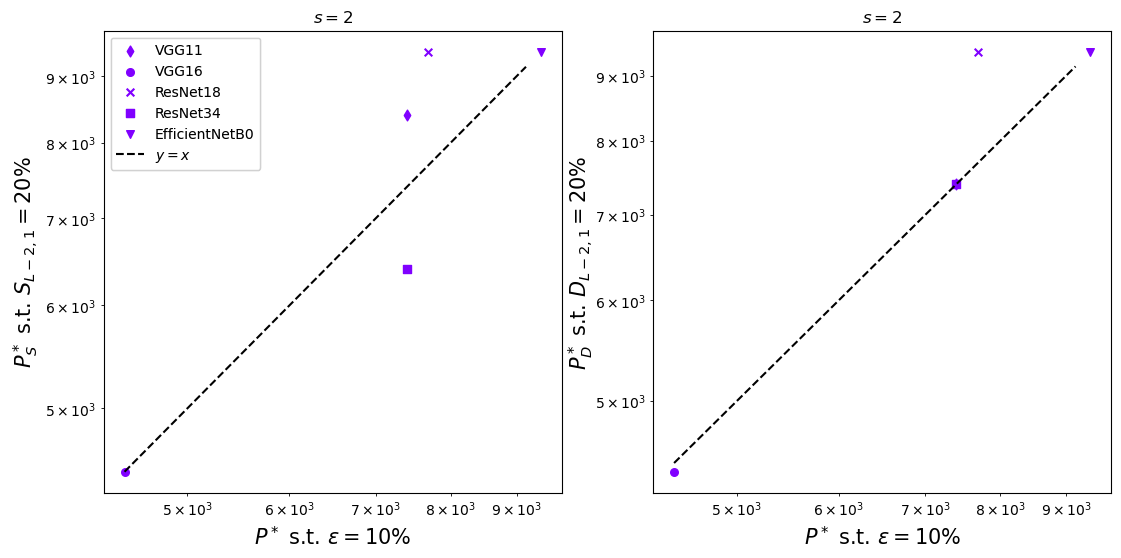

In [30]:
ns = ns = np.array([10])
s0s = [2]
    
Ls= [2]
sss = [2]
nets = ['VGG11','VGG16','ResNet18','ResNet34','EfficientNetB0']

colors = cm.rainbow(np.linspace(0, 1, len(ns)))

fig, axs = plt.subplots(1,2, figsize = (13,6))

vs0 = []
vs1 = []
for (idxnet,net) in enumerate(nets):
    for (idx_s,s) in enumerate(sss):
        if s==2: idxx = 0
        if s==3: idxx = 1
            

        for (idx_L,L) in enumerate(Ls):
       
        
          
            if L==2:
                alpha = 1
                size = 30
            elif L==3:
                alpha = 1
                size =150
    
            for (idx_s0,s0) in enumerate(s0s):
               
    
                if idxnet==0:
                    mar = "d"
                elif idxnet==1:
                    mar = "o"
                elif idxnet==2:
                    mar = "x"
                elif idxnet==3:
                    mar = "s"
                elif idxnet==4:
                    mar = "v"
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    try:
                        print('ok')
                        pstars_task = torch.load('pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        pstars_pos = torch.load('pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        pstars_sem = torch.load('pstars/pstars_sem_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        #print([pstars_task],[pstars_sem])
                        pstars_task = np.array(pstars_task)
                        pstars_pos = np.array(pstars_pos)
                        pstars_sem = np.array(pstars_sem)
                        col = colors[idxn]
                        print(pstars_task,pstars_sem,pstars_pos)
                        if pstars_task:
                            
                            pstars_task = pstars_task*n
                            pstars_sem = pstars_sem*n
                            pstars_pos = pstars_pos*n

                            axs[0].scatter(pstars_task,pstars_sem,label = net ,marker = mar,color = col,s=size, alpha = alpha)
                            axs[1].scatter(pstars_task,pstars_pos,marker = mar,color = col,s=size, alpha = alpha)

    
                            
                            vs0+=[pstars_task]
                            #print('ok')
                    except:
                        pass
                    
min0 = min(vs0)
max0 = max(vs0)
print(min0,max0)

ps = np.arange(min0,max0,(max0-min0)/20)

axs[0].plot(ps,ps,label=r'$y=x$',color='black',ls='--')

axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].set_xlabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[1].set_xlabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[0].set_ylabel(r'$P_S^*$ s.t. $S_{L-2,1} = 20\%$',size = 15)
#axs[0].set_ylabel(r'$P_S^*$ s.t. $S_{L-2,1} = 20\%$',size = 15)
# see above for threshod


#axs[1].set_xlabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[1].set_ylabel(r'$P_D^*$ s.t. $D_{L-2,1} = 20\%$',size = 15,labelpad = 0)
#axs[1].set_ylabel(r'$P_D^*$ s.t. $D_{L-2,1} = 20\%$',size = 15,labelpad = -1)

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$L=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$L=3$')

first_legend = axs[0].legend()
ax = axs[0].add_artist(first_legend)

#axs[0].legend(handles=[s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
#second_legend = axs.legend()
axs[0].set_title(r"$s=2$")
axs[1].set_title(r"$s=2$")

#axs[0].set_title(r"$s=3$")#,y=1.0,pad = -14)
#axs[1].set_title(r"$s=3$")#,y=1.0,pad = -14)
#axs.legend(handles=[s2,s3],loc = 'lower left') 
#legend3 = axs.legend(loc='lower right')
#second_legend = axs.legend()
#ax = axs.add_artist(second_legend)
plt.savefig("figures/pstar_sem_pos_new_nets_s0_L.png", bbox_inches='tight')
plt.savefig("figures/pstar_sem_pos_new_nets_s0_L.pdf" , bbox_inches='tight')